# plot loss curves

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle as pk
import os

# here..
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


x_y_label_font = 20
x_y_legend_font = 20

plt.rc('font', family='Times New Roman')
fig_dpi = 220
fig_shape_squre = (6, 5)

def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh), dpi=100)
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list
    plt.show()

class MyColor(object):
    def __init__(self, cmap_name, skip_idx=5, backup_name='Set1', backup_color=3):
        self.color_set  = plt.get_cmap(cmap_name).colors
        self.backup_set = plt.get_cmap(backup_name).colors
        self.backup_color = backup_color
        self.skip_idx=skip_idx
        self.idx = 0
        self.color_len = len(self.color_set)
        
    def get_color(self):
        if self.idx == self.color_len - 1:
            self.idx = 0
        if self.idx == self.skip_idx:
            self.idx += 1
            return self.backup_set[self.backup_color]
        color = self.color_set[self.idx]
        self.idx += 1
        return color
    
def lighten_color(color, amount=0.3):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


plot_color_gradients('Qualitative',
                     ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
                      'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
                      'tab20c'])

<Figure size 640x338.2 with 13 Axes>

In [ ]:
# TODO: load from file
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


dataset_name = 'MolecularFingerprint_REDDIT-BINARY_assessment'

def load_logs(date=None, name=None) -> dict:
    
    def extract_data(data_path) -> list:
        with open(data_path, 'r') as f:
            data = []
            for line in f.readlines():
                if not line.startswith('Epoch'):
                    continue
                
                line = line.strip().replace(',', '')
                l = line.split(' ')
                s_l = [l[4], l[7], l[10], l[13], l[16], l[19], l[-1]]
                f_l = []
                for i in s_l:
                    try:
                        fi = float(i)
                    except Exception as e:
                        fi = 0.0
                    f_l.append(fi)
                        
                data.append(f_l)
            return np.array(data)
    
    if date is not None:
        root_dir = f'results/result_{date}/'
        dirs = os.listdir(f'results/result_{date}/')
        print(dirs)
        dataset_log = {}
        for d in dirs:
            dd = os.path.join(root_dir, d, '10_NESTED_CV')
            outer_dirs = os.listdir(dd)
            log_folds = []
            for i, id_name in enumerate(outer_dirs):
                if not os.path.isdir(os.path.join(dd, id_name)):
                    continue
                """
                Epoch: 1, TR loss: 433.2928585476345 TR acc: 48.641975308641975, VL loss: 479.35484415690104 VL acc: 47.77777854071723 TE loss: 101.24097244262695 TE acc: 39.0
                Epoch: 10, TR loss: 9.24662885548156 TR acc: 65.4320987654321, VL loss: 324.07152099609374 VL acc: 70.00000135633681 TE loss: 13.453640460968018 TE acc: 62.0
                Epoch: 20, TR loss: 11.454432420377378 TR acc: 59.75308641975309, VL loss: 148.55850830078126 VL acc: 54.444445376926 TE loss: 30.56077377319336 TE acc: 53.0
                Epoch: 30, TR l
                """
                file_dir = os.path.join(dd, id_name, 'experiment.log')
                data = extract_data(file_dir)
                log_folds.append(data)
            dataset_log[d] = log_folds
        return dataset_log
    
    elif name is not None:
        # TODO: search the best config:
        root_path = f"results/{name}/"
        print('input root_path:', root_path)
        assert os.path.exists(root_path)
        
        dirs = os.listdir(root_path)
        
        folds_data = {} # TODO store data.
        for d in dirs:
            # search 10 folds:
            folds = []
            for i in range(1, 11):
                fold_dir = os.path.join(root_path, d, f'10_NESTED_CV/OUTER_FOLD_{i}/HOLDOUT_MS/')
                configs = os.listdir(fold_dir)
                # print winner config. TODO.
                best_vl_acc = 0.0
                best_conf = None
                if len(configs) < 3:
                    # only one config.
                    best_conf = 'config_1'
                else:
                    for cf in configs:
                        if not os.path.isdir(os.path.join(fold_dir,cf)):
                            continue
                        config_res = os.path.join(fold_dir, cf, 'experiment.log')
                        with open(config_res,'r') as f:
                            for l in f.readlines():
                                if 'best' in l:
                                    vlacc = float(l.split(' ')[9].split(',')[0])
                                    if vlacc > best_vl_acc:
                                        best_conf = cf
                                        best_vl_acc = vlacc
                                    
                # print('best_conf:', best_conf, 'acc:', best_vl_acc)
                # TODO: load the best again.
                best_conf_path = os.path.join(fold_dir, best_conf, 'experiment.log')
                best_data = extract_data(best_conf_path)
                folds.append(best_data)
            folds_data[d] = folds
        
        return folds_data
                
                
        # with open()
"""
Epoch: 750, TR loss: 1.7823815012174378 TR acc: 13.374485612406161, VL loss: 1.8264499328754566 VL acc: 16.666666949236834 TE loss: None TE acc: None
Stopping at epoch 751, best is (1.9384536331082567, 17.489711965553063, 1.841690769901982, 22.22222222222222, None, None, 251)
TR Accuracy: 17.489711965553063 VL Accuracy: 22.22222222222222
"""
    

# Plot best:

In [ ]:
# TODO: plot

# TODO: def histogram
def plot_loss_curve(data_states:list=None, titles:list=None):

    total = len(data_states)
    
    if total == 1:
        folds = data_states[0]
        name = titles[0]
        
        fig, axes = plt.subplots(4, 3, figsize=(10, 8), dpi=300)
        for idx, fold in enumerate(folds):
            axe = axes[int(idx/3)][idx%3]
            
            axe.plot(fold[:, 0]) # train loss
            axe.plot(fold[:, 2]) # val loss
            axe.set_ylim(0, 5)
            # TODO: acc, right axis
            
            axe.set_title(f'fold: {idx}')
        if len(folds)%3 > 0:
            for d in range(3-total%3):
                fig.delaxes(axes[-1][-d-1])
        fig.suptitle(','.join(name.split('_')[:2]) +"," + name.split('_')[-1])
        fig.legend(['train loss', 'val_loss'], loc='lower right')
        # fig.title(','.join(name.split('_')[:2]))
    
    plt.tight_layout()
    plt.show()
    
    
# plot gradient L2 norm:

def plot_gradientnorm_curve(data_states:list=None, figure_title=None, titles:list=None, rolling=False):

    total = len(data_states)
    
    if total == 1:
        folds = data_states[0]
        name = titles[0]
        
        fig, axes = plt.subplots(4, 3, figsize=(10, 12), dpi=300)
        # plt.yscale("log")  
        for idx, fold in enumerate(folds):
            axe = axes[int(idx/3)][idx%3]
            axe.set_yscale('log', subs=[0, 1, 2, 3, 4, 5, 6, 7, 8])
            if rolling:
                df = pd.DataFrame(fold[:, -1])
                axe.plot(df[0], 'lightblue', df[0].rolling(10).mean(), 'b') # gradient norm
            else:
                axe.plot(fold[:, -1]) # gradient norm
            # TODO: acc, right axis
            
            axe.set_title(f'fold: {idx}')
        if len(folds)%3 > 0:
            for d in range(3-total%3):
                fig.delaxes(axes[-1][-d-1])
        fig.suptitle(','.join(name.split('_')[:2]) + "," +name.split('_')[-1])
        fig.legend(['train loss', 'val_loss'], loc='lower right')
        # fig.title(','.join(name.split('_')[:2]))
    else: # multi datasets:
        fig, axes = plt.subplots(4, 3, figsize=(10, 12), dpi=300)
        last_leg = []
        color = MyColor(cmap_name='Set1')
        for i, folds in enumerate(data_states):
            # plt.yscale("log")  
            cc = color.get_color()
            for idx, fold in enumerate(folds):
                axe = axes[int(idx/3)][idx%3]
                axe.set_yscale('log', subs=[0, 1, 2, 3, 4, 5, 6, 7, 8])
                if rolling:
                    df = pd.DataFrame(fold[:, -1])
                    # axe.plot(df[0], color=lighten_color(cc), alpha=0.4)
                    axe.plot(df[0].rolling(12).mean(), color=cc, label=titles[i]) # gradient norm
                else:
                    axe.plot(fold[:, -1], label=titles[i])  # gradient norm
                # TODO: acc, right axis
                axe.set_title(f'fold: {idx}')
                
        if len(folds)%3 > 0:
            for d in range(3-total%3):
                fig.delaxes(axes[-1][-d-1])
        handlers, labels = axes[0][0].get_legend_handles_labels()
        fig.legend(handlers, labels, loc='lower right')
        fig.suptitle(figure_title)
        
    
    plt.tight_layout()
    plt.show()


In [ ]:
stats = load_logs(name='result_GIN_0202') # random

# random, overfitting!!
for k, v in stats.items():
    loss_log, titles = [], []
    loss_log.append(v)
    titles.append(k + "_Random")
    plot_loss_curve(loss_log, titles)
    plot_gradientnorm_curve(loss_log, titles)
    
    

In [ ]:
stats = load_logs(name='result_GIN_0202_attr')

# attr, SOTA!!
for k, v in stats.items():
    loss_log, titles = [], []
    loss_log.append(v)
    titles.append(k)
    plot_loss_curve(loss_log, titles)
    plot_gradientnorm_curve(loss_log, titles)

# eigen

In [ ]:
stats = load_logs(name='result_GIN_0202_eigen')
# stats = load_logs(name='result_GIN_0202_pagerank')
# TODO: plot all config_17 or the best config?

In [ ]:
for k, v in stats.items():
    loss_log, titles = [], []
    loss_log.append(v)
    titles.append(k+"_Eigenvector")
    plot_loss_curve(loss_log, titles)
    plot_gradientnorm_curve(loss_log, titles)

# Pagerank

In [ ]:
stats = load_logs(name='result_GIN_0202_pagerank')
for k, v in stats.items():
    loss_log, titles = [], []
    loss_log.append(v)
    titles.append(k+"_Pagerank")
    plot_loss_curve(loss_log, titles)
    plot_gradientnorm_curve(loss_log, titles)

# degree

In [ ]:
stats = load_logs(name='result_GIN_0202_degree')
for k, v in stats.items():
    loss_log, titles = [], []
    loss_log.append(v)
    titles.append(k+"_Degree")
    plot_loss_curve(loss_log, titles)
    plot_gradientnorm_curve(loss_log, titles, rolling=True)

In [ ]:
stats = load_logs(name='result_GIN_0202_degree_large_batchsize')
for k, v in stats.items():
    loss_log, titles = [], []
    loss_log.append(v)
    titles.append(k+"_Degree_largeBatch")
    plot_loss_curve(loss_log, titles)
    plot_gradientnorm_curve(loss_log, titles, rolling=True)
    
    # No difference !!

# TODO: using different node initializations:

In [ ]:
stats_1023 = load_logs(date=1023)

for k, v in stats_1023.items():
    print('dataset name: ', k, 'fold len:', len(v))


In [ ]:
for k, v in stats_1023.items():
    loss_log, titles = [], []
    loss_log.append(v)
    titles.append(k)
    plot_loss_curve(loss_log, titles)
    
# has N fold.
# TODO: plot N fold first, then we may pick one best.

In [ ]:
# NOTE: compare the loss curves of normed and unnormed random feature on MUTAG:



stats_randnorm = load_logs(name='result_GIN_0207_random_norm')

    
loss_log, titles = [], []
for k, v in stats_randnorm.items():
    loss_log.append(v)
    titles.append(k)
    plot_loss_curve(loss_log, titles)
    break
    
# has N fold.
# TODO: plot N fold first, then we may pick one best.


# TODO: Plot all gradient norm curves into one figure.

In [ ]:
degree_states = load_logs(name='result_GIN_0202_degree') # random
random_states = load_logs(name='result_GIN_0202') # random
eigen_states = load_logs(name='result_GIN_0202_eigen') # random
pagerank_states = load_logs(name='result_GIN_0202_pagerank') # random
attr_states = load_logs(name='result_GIN_0202_attr') # random

def extend_value(stat:dict):
    return [v for v in stat.values()]

all_stats = [degree_states, random_states, eigen_states, pagerank_states, attr_states]
loss_logs = []
[loss_logs.extend(extend_value(s)) for s in all_stats]

titles = ['degree', 'random', 'eigen', 'pagerank', 'attr']

plot_gradientnorm_curve(loss_logs,'GIN,mutag' ,titles, rolling=True)

In [ ]:
# compare real, low, high range of degree on MUTAG:

states1 = load_logs(name='result_GIN_0202_degree') # random
states2 = load_logs(name='result_GIN_0209_rand_id_3') # random
states3 = load_logs(name='result_GIN_0209_rand_id_1000') # random

def extend_value(stat:dict, name:str=None):
    if name is None:
        return [v for v in stat.values()]
    else:
        for k, v in stat.items():
            k = k.upper()
            if name.upper() in k:
                return [v]

all_stats = [states1, states2, states3]
loss_logs = []
for s in all_stats:
    print(s.keys())
    loss_logs.extend(extend_value(s, name='mutag'))

titles = ['real degree', 'low:1-3', 'high:1-1000']

plot_gradientnorm_curve(loss_logs,'GIN,mutag' ,titles, rolling=True)

# plot node feature dist:

In [36]:
# load npy or dataset.


def plot_load_features(fea_path=None, fea=None):
    
    if fea is None:
        with open(fea_path, 'rb') as f:
            node_feature = pk.load(f)
            # NOTE: pack into feature dist
            print(node_feature[0].shape, node_feature[1].shape)
            fea = np.concatenate(node_feature, axis=0)
         
    # note plot dist:
    plt.figure()
    plt.hist(fea[:, 0], 100, density=False, facecolor='g', alpha=0.75)
    plt.xlabel('degree')
    plt.ylabel('node amount')
    plt.show()
    
    return fea
        


(17, 1) (13, 1)


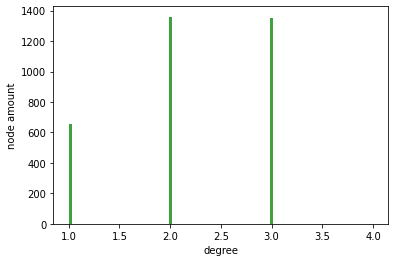

(3371, 1)


In [33]:
mutag_node_fea = plot_load_features('/li_zhengdao/github/GenerativeGNN/DATA/MUTAG/processed/MUTAG_add_degree.pkl')
print(mutag_node_fea.shape)

(20, 1) (32, 1)


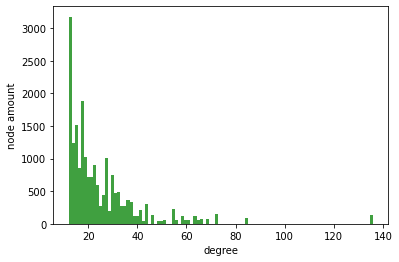

(19773, 1)


In [34]:
imdb_node_fea = plot_load_features('/li_zhengdao/github/GenerativeGNN/DATA/IMDB-BINARY/processed/IMDB-BINARY_add_degree.pkl')
print(imdb_node_fea.shape)

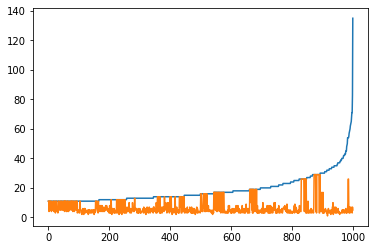

In [4]:

with open('/li_zhengdao/github/GenerativeGNN/DATA/IMDB-BINARY/processed/IMDB-BINARY_add_degree.pkl', 'rb') as f:
    node_feature = pk.load(f)
    dd = []
    for n in node_feature:
        dd.append((np.max(n),np.min(n)))
    # sort:
    sdd = sorted(dd, key=lambda x:x[0])
    max_dd = [s[0] for s in sdd]
    min_dd = [s[1] for s in sdd]
    
    plt.figure()
    plt.plot(max_dd)
    plt.plot(min_dd)
    plt.show()

In [8]:
for i in range(10):
    a = np.random.randint(1, 2)
    print(a)

1
1
1
1
1
1
1
1
1
1


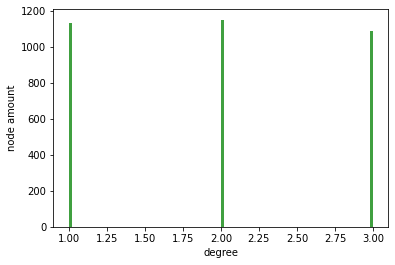

In [42]:
def generate_idfea():
    feas = []
    with open('/li_zhengdao/github/GenerativeGNN/DATA/MUTAG/processed/MUTAG_add_degree.pkl', 'rb') as f:
        node_feature = pk.load(f)
        # NOTE: pack into feature dist
        for no in node_feature:
            feas.append(np.random.randint(1, int(4*1.0), size=no.shape[0]).reshape(no.shape[0], 1).astype(np.float32))
    return np.concatenate(feas, axis=0)

id_fea = plot_load_features(fea=generate_idfea())

In [45]:
# TODO: check label balance:
1-63.0/(188.0)



0.6648936170212766

# TODO: pick the best config from each fold?
# what is the majority one?